In [1]:
#titanic에서 데이터 분석한 결과를 가지고 데이터를 전처리 한후 Xgboost를 사용해서 예측률을 높여본다.
# Xgboost에서 하이퍼파라미터를 어떻게 조정할지에 대한 방법을 연습한다.
# 여기서는 Xgboost model에 대한 이해를 높이는데 중점을 둔다.
# grid_search
# 2020.5.12

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier
import xgboost as xgb
from bayes_opt import BayesianOptimization

titanic_data = pd.read_csv('titanic_train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#불필요한 요소 삭제
titanic_data = titanic_data.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
# cabin정보의 missing을 N으로 선실번호에서 앞자만 사용
titanic_data.Cabin.fillna('N', inplace = True)
titanic_data['H_Cabin'] = titanic_data['Cabin'].apply(lambda x : x[0])
#missing value 처리
#Age는 평균값으로 처리
titanic_data.Age.fillna(titanic_data.Age.mean(), inplace = True)
#Cabin은 삭제하고 H_cabin사용
titanic_data = titanic_data.drop(['Cabin'], axis = 1)
#Embarked는 가장 많은  S로
titanic_data.Embarked.fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,H_Cabin
0,0,3,male,22.0,1,0,7.2500,S,N
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,N
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,N


In [3]:
# 중요한 요소이긴 하지만 2이상은 데이터가 적어서, 있으면 1 없으면 0으로
titanic_data['SibSp'] = titanic_data['SibSp'].apply(lambda x : 1 if x > 0 else 0)

#분류 값들을 수치값으로 변경
titanic_data.Sex.replace({'male': 0.0, 'female': 1.0}, inplace= True)

#Dependents 값을 get_dummies 함수를 이용해서 수치로 변경 OneHotEncode를 사용해도 된다.
#drop first를 True로 해서 dummy trap을 피한다.
dummies = pd.get_dummies(titanic_data['Embarked'], prefix='Embarked', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['Embarked'],  axis=1)

dummies = pd.get_dummies(titanic_data['H_Cabin'], prefix='Cabin', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['H_Cabin'],  axis=1)

# 더 많은 column을 보여주도록 변경
pd.set_option('display.max_columns', 100) 
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,0,3,0.0,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,1,0
1,1,1,1.0,38.0,1,0,71.2833,0,0,0,1,0,0,0,0,0,0
2,1,3,1.0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0
3,1,1,1.0,35.0,1,0,53.1000,0,1,0,1,0,0,0,0,0,0
4,0,3,0.0,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,1,0


In [4]:
#Test를 위한 데이터 생성
y_data = titanic_data.Survived
x_data = titanic_data.drop('Survived', axis = 1)
#test 와 train set 만들기
X_train, X_test, y_train, y_test= train_test_split(x_data, y_data, test_size=0.2, random_state=123)

In [5]:
# 평가 함수 선언
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))    

In [6]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, early_stopping_rounds=50)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[102  12]
 [ 12  53]]
정확도: 0.8659, 정밀도: 0.8154, 재현율: 0.8154,    F1: 0.8154, AUC:0.9138


In [7]:
# xgb00st model의 파라미터들을 볼 수 있다.
print(xgb_wrapper)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


# 파라미터 튜닝을위한 일반적인 접근법

수행 할 다양한 단계는 다음과 같습니다.

1. 상대적으로 높은 학습률(learning_rate)을 선택.
일반적으로 0.1의 learning_rate는 작동하지만 0.05 ~ 0.3의 어딘가에서 다른 문제에 대해 작동합니다. 이 학습률에 대한 최적의 트리 수를 결정하십시오 . XGBoost는“cv”라고하는 매우 유용한 기능을 가지고 있는데, 이는 각 부스팅 반복마다 교차 유효성 검사를 수행하여 필요한 최적의 트리 수를 반환합니다.
2. 결정된 학습 속도 및 트리 수에 대한 tree-specific parameters(max_depth, min_child_weight, gamma, subsample, colsample_bytree)를 조정
트리를 정의하기 위해 다른 매개 변수를 선택할 수 있으며 여기에서 예를 들어 보겠습니다.
3. regularization parameters(람다, 알파) 조정.
  모델의 복잡성을 줄이고 성능을 향상 도움이 될 수 있습니다 
4. 학습률 을 낮추고 최적의 매개 변수를 결정

보다 자세한 단계별 접근 방식을 살펴 보겠습니다.

# Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

파라미터를 결정하려면 다른 파라미터의 초기 값을 설정해야합니다.

1. max_depth = 5 : 
 3-10 사이 여야합니다. 5부터 시작했지만 다른 숫자를 선택할 수도 있습니다. 4-6은 좋은 출발점이 될 수 있습니다.
2. min_child_weight = 1 : 
클래스의 불균형이 높고 leaf node의 그룹 크기가 작을수록 더 작은 값이 선택됩니다.
3. gamma = 0 : 
0.1-0.2와 같은 더 작은 값도 시작할 수 있습니다. 이것은 나중에 조정될 것입니다.A smaller value like 0.1-0.2 can also be chosen for 
4. subsample, colsample_bytree = 0.8 : 
이것은 일반적으로 사용되는 시작 값입니다. 일반적인 값의 범위는 0.5-0.9입니다.
5. scale_pos_weight = 1: 
높은 클래스 불균형으로 인해

위의 모든 내용은 초기 추정치이며 나중에 조정될 것입니다. 여기에서 기본 학습 속도 0.1을 사용하고 xgboost의 cv 함수를 사용하여 최적의 트리 수를 확인하십시오.

오차 행렬
[[98 16]
 [12 53]]
정확도: 0.8436, 정밀도: 0.7681, 재현율: 0.8154,    F1: 0.7910, AUC:0.9086
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       114
           1       0.77      0.82      0.79        65

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.85      0.84      0.84       179



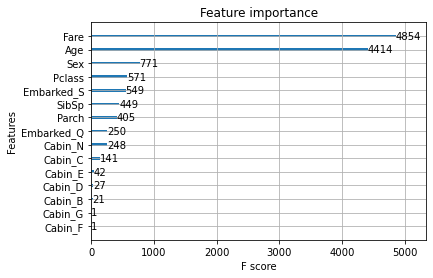

In [8]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(X_train, y_train)
xgb_pred = xgb1.predict(X_test)
xgb_pred_proba = xgb1.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , xgb_pred, xgb_pred_proba)
print(classification_report(y_test, xgb_pred))
xgb.plot_importance(xgb1)

# Step 2: Tune max_depth and min_child_weight
    
모델 결과에 가장 큰 영향을 미치므로 먼저 조정합니다. 먼저 더 넓은 범위를 설정 한 다음 더 작은 범위에 대해 다른 반복을 수행합니다.
Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [10]:
from sklearn.model_selection import GridSearchCV

param_test1 = { 'max_depth': [3, 5, 7, 9], 'min_child_weight': [1,3,5,7] } 

xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch1 = GridSearchCV(xgb2, param_grid = param_test1, scoring='roc_auc',iid=False, cv=3)
gsearch1.fit(X_train, y_train)

print("최적화 파라미터 :", gsearch1.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch1.best_score_))

C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


최적화 파라미터 : {'max_depth': 9, 'min_child_weight': 3}
GridSearch_CV 최고정확도: 0.8559


여기에서는 12 개의 조합을 실행했습니다. 
이상적인 값은 MAX_DEPTH 9 및 min_child_weight 3 . 한 걸음 더 깊이 들어가서 최적의 값을 찾으십시오. 
간격이 2이기 때문에 최적의 값 위와 아래의 값 1을 검색합니다.

In [10]:
param_test2 = { 'max_depth': [8, 9, 10], 'min_child_weight': [2,3,4] } 

xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch2 = GridSearchCV(xgb2, param_grid = param_test2, scoring='roc_auc',iid=False, cv=3)
gsearch2.fit(X_train, y_train)

print("최적화 파라미터 :", gsearch2.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch2.best_score_))

최적화 파라미터 : {'max_depth': 9, 'min_child_weight': 4}
GridSearch_CV 최고정확도: 0.8561


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


최적의 값을 얻을 MAX_DEPTH 9 및 min_child_weight 4 . 또한 CV 점수가 약간 증가하는 것을 볼 수 있습니다. 
모델 성능이 향상됨에 따라 성능이 약간 향상되는 것은 기하 급수적으로 어려워집니다.

# Step 3: gamma 조정
gamma는 다양한 값을 취할 수 있지만 여기서 5 개의 값을 확인하겠습니다. 보다 정확한 값으로 들어갈 수 있습니다.

In [11]:
param_test3 = { 'gamma':[i/10.0 for i in range(0,5)]}

xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch3 = GridSearchCV(xgb3, param_grid = param_test3, scoring='roc_auc',iid=False, cv=3)
gsearch3.fit(X_train, y_train)

print("최적화 파라미터 :", gsearch3.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch3.best_score_))

최적화 파라미터 : {'gamma': 0.0}
GridSearch_CV 최고정확도: 0.8561


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


이것은 우리의 원래 gamma 값, 즉 0이 최적의 값임을 보여줍니다

In [12]:
#grid로 찾은 최적화 파라미터로 예측
best_xgb = gsearch3.best_estimator_
xgb_pred = best_xgb.predict(X_test)
print("Best Grid RF:{0:.4f}".format(accuracy_score(y_test,xgb_pred)))
print(classification_report(y_test, xgb_pred))

Best Grid RF:0.8715
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       114
           1       0.81      0.85      0.83        65

    accuracy                           0.87       179
   macro avg       0.86      0.87      0.86       179
weighted avg       0.87      0.87      0.87       179



# Step 4: subsample 과 colsample_bytree 조정
다음 단계는 다른 ubsample과 colsample_bytree 값을 시도하는 것입니다. 이를 2 단계로 수행하고 둘 다 시작하려면 0.6,0.7,0.8,0.9 값을 사용하십시오.

In [13]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb4 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch4 = GridSearchCV(xgb4, param_grid = param_test4, scoring='roc_auc',iid=False, cv=3)
gsearch4.fit(X_train, y_train)

print("최적화 파라미터 :", gsearch4.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch4.best_score_))

최적화 파라미터 : {'colsample_bytree': 0.6, 'subsample': 0.9}
GridSearch_CV 최고정확도: 0.8565


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Now we should try values in 0.05 interval around these. colsample_bytree': 0.6, 'subsample': 0.9

In [14]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
xgb5 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch5 = GridSearchCV(xgb5, param_grid = param_test5, scoring='roc_auc',iid=False, cv=3)
gsearch5.fit(X_train, y_train)
print("최적화 파라미터 :", gsearch5.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch5.best_score_))

최적화 파라미터 : {'colsample_bytree': 0.6, 'subsample': 0.9}
GridSearch_CV 최고정확도: 0.8565


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


변화가 없다 따라서 최적은 {'colsample_bytree': 0.6, 'subsample': 0.9}

# 5 단계 : 정규화 매개 변수 조정

다음 단계는 정규화를 적용하여 과적 합을 줄이는 것입니다. 감마가 복잡성을 제어하는 ​​실질적인 방법을 제공하기 때문에 많은 사람들이이 매개 변수를 사용하지 않지만. 그러나 항상 시도해야합니다. 여기에서 'reg_alpha'값을 조정하고 다른 값의 'reg_lambda'를 시도하도록 당신에게 맡기십시오.

In [15]:
#이거 조정하는것은 너무 길어서 한단계 건너뛰었다 . 
#이 부분은https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 참고
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]
}
xgb7 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch7 = GridSearchCV(xgb7, param_grid = param_test7, scoring='roc_auc',iid=False, cv=3)
gsearch7.fit(X_train, y_train)
print("최적화 파라미터 :", gsearch7.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch7.best_score_))

최적화 파라미터 : {'reg_alpha': 0.01}
GridSearch_CV 최고정확도: 0.8568


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [16]:
#grid로 찾은 최적화 파라미터로 예측
best_xgb = gsearch7.best_estimator_
xgb_pred = best_xgb.predict(X_test)
print("Best Grid RF:{0:.4f}".format(accuracy_score(y_test,xgb_pred)))
print(classification_report(y_test, xgb_pred))

Best Grid RF:0.8771
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       114
           1       0.82      0.85      0.83        65

    accuracy                           0.88       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.88      0.88      0.88       179



# Step 6: Learning Rate and tree 수
Lastly, we change the learning rate and  trees. Lets use the cv function of XGBoost to do the job again.

In [17]:
param_test8 = {
 'learning_rate':[0.2, 0.15, 0.1, 0.05]
}
xgb8 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,reg_alpha= 0.01,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch8 = GridSearchCV(xgb8, param_grid = param_test8, scoring='roc_auc',iid=False, cv=3)
gsearch8.fit(X_train, y_train)
print("최적화 파라미터 :", gsearch8.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch8.best_score_))


최적화 파라미터 : {'learning_rate': 0.1}
GridSearch_CV 최고정확도: 0.8568


C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [21]:
param_test9 = {
 'n_estimators':[10, 50, 100, 200, 300]
}
xgb9 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,reg_alpha= 0.01,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
gsearch9 = GridSearchCV(xgb9, param_grid = param_test9, scoring='roc_auc', cv=3)
gsearch9.fit(X_train, y_train)
print("최적화 파라미터 :", gsearch9.best_params_)
print("GridSearch_CV 최고정확도: {0:.4f}".format(gsearch9.best_score_))
gsearch9_df = pd.DataFrame(gsearch9.cv_results_)
gsearch9_df

최적화 파라미터 : {'n_estimators': 50}
GridSearch_CV 최고정확도: 0.8595


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012802,0.002241,0.001996,2.503080e-06,10,{'n_estimators': 10},0.819874,0.810307,0.878523,0.836235,0.030156,5
1,0.038764,0.003186,0.002013,1.185878e-05,50,{'n_estimators': 50},0.869188,0.810982,0.898351,0.859507,0.036319,1
2,0.069480,0.001544,0.001994,5.947204e-07,100,{'n_estimators': 100},0.865406,0.811844,0.891454,0.856235,0.033141,2
3,0.133513,0.004398,0.001994,1.173403e-06,200,{'n_estimators': 200},0.865628,0.808621,0.882984,0.852411,0.031765,3
4,0.192129,0.004701,0.002670,4.748810e-04,300,{'n_estimators': 300},0.867927,0.811919,0.874738,0.851528,0.028145,4


Best Grid Xgbm accuracy score:0.8715
오차 행렬
[[102  12]
 [ 11  54]]
정확도: 0.8715, 정밀도: 0.8182, 재현율: 0.8308,    F1: 0.8244, AUC:0.9026
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       114
           1       0.82      0.83      0.82        65

    accuracy                           0.87       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179



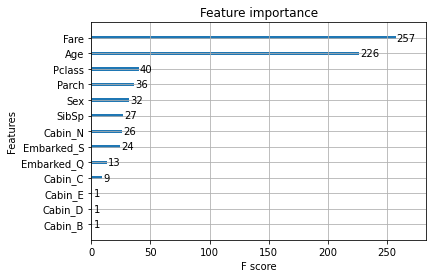

In [22]:
#grid로 찾은 최적화 파라미터로 예측
best_xgb = gsearch9.best_estimator_
xgb_pred = best_xgb.predict(X_test)
print("Best Grid Xgbm accuracy score:{0:.4f}".format(accuracy_score(y_test,xgb_pred)))
xgb_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , xgb_pred, xgb_pred_proba)
print(classification_report(y_test, xgb_pred))
xgb.plot_importance(best_xgb)